In [1]:
# All imports
from pathlib import Path
import warnings
from typing import Any, Tuple, Union
import cv2
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [4]:
BASE: Path = Path("../bleaching_data_RS")
IMG_DIR: Path = BASE / "images"
MASKS_BLEACHED_DIR: Path = BASE / "masks_bleached"
MASKS_UNBLEACHED_DIR: Path = BASE / "masks_non_bleached"


def find_mask_triple(img_path: Path) -> Union[Tuple[Path, Any, Any], Tuple[Path, None, None]]:
    """
    Group the original and mask image files based on their stem.
    The stem is the original file name without the file extension. 
    As this is the same for all 3 images, it will select them all. 

    Args:
        img_path (Path): file path of an image in the "images" folder

    Returns:
        tuple[Path, Any, Any] | tuple[Path, None, None]: tuple of file paths for all equal images (original + 2 masks)
    """
    image_stem = img_path.stem 

    bleached_path = MASKS_BLEACHED_DIR / f"{image_stem}_bleached.png"
    unbleached_path = MASKS_UNBLEACHED_DIR / f"{image_stem}_non_bleached.png"
    if bleached_path.exists() and unbleached_path.exists(): # Check that all 3 versions of the image are there, and group them
        return img_path, bleached_path, unbleached_path
    return img_path, None, None

# Build the dataset
triple: list[Any] = []
for img_path in IMG_DIR.glob("*.jpg"):
    img_path, bleached_path, non_bleached_path = find_mask_triple(img_path)
    if bleached_path is None or non_bleached_path is None:  # Warning if there is a missing mask
        print(f"[WARN] Missing masks for {img_path.name}")
        continue
    triple.append((img_path, bleached_path, non_bleached_path))

print(f"Found {len(triple)} image/mask triples.")

Found 658 image/mask triples.


In [ ]:
def srgb_to_linear(color_channel_array: npt.NDArray[np.uint8]) -> npt.NDArray[np.float32]:
    """
    To invert the nonlinear scale, a specific formula needs to be applied based on the value of the pixel. 
    If the value is lower or equal to 0.04045, then the value should be divided by 12.92.
    If the value is higher than 0.04045, then v = ((v+0.055) / 1.055) ^ 2.4

    Args:
        color_channel_array (npt.NDArray[np.uint8]): 2D array of a color channel

    Returns:
        npt.NDArray[np.float32]: 2D array of the linearized color channel.
    """
    x = color_channel_array.astype(np.float32) / 255.0  # First convert the pixel values to [0,1] scale
    return np.where(x <= 0.04045, x / 12.92, ((x + 0.055) / 1.055) ** 2.4).astype(np.float32)

def robust_unit(x: np.ndarray, mask: np.ndarray | None) -> np.ndarray:
    # Ensure float32
    x = x.astype(np.float32, copy=False)
    H, W = x.shape[:2]

    if mask is None:
        mask = np.ones((H, W), dtype=bool)
    else:
        mask = mask.astype(bool, copy=False)
        if mask.shape[:2] != (H, W):
            mask = np.ones((H, W), dtype=bool)  # last-resort fallback

    vals = x[mask]
    vals = vals[np.isfinite(vals)]

    if vals.size < 4:
        base = x[np.isfinite(x)]
        if base.size < 4:
            return np.zeros_like(x, dtype=np.float32)
        p1, p99 = np.percentile(base, [1, 99])
    else:
        p1, p99 = np.percentile(vals, [1, 99])

    # Cast percentiles to float32 to prevent upcasting x to float64
    p1  = np.float32(p1)
    p99 = np.float32(p99)
    denom = np.float32(max(p99 - p1, 1e-6))

    # In-place normalize and clip to avoid extra big allocations
    y = x.copy()                   # one working buffer
    y -= p1                        # in-place
    y /= denom                     # in-place
    np.clip(y, 0.0, 1.0, out=y)    # in-place
    return y

def create_all_scores(bgr_img: npt.NDArray[np.uint8], mask_matrix: npt.NDArray[np.bool_]) -> Tuple[Any, Any, Any, Any, Any, Any]:
    """
    Converts an image and its mask into all the visual traits we want to investigate. 

    Args:
        bgr_img (npt.NDArray[np.uint8]): 3D matrix of (HxWxc) with c being the color channel.
        mask_matrix (npt.NDArray[np.uint8]): 2D matrix of (HxW).

    Returns:
        Tuple[Any, Any, Any, Any, Any, Any]: A tuple with bgr_GW, LAB_img, raw_red_score, albedo_score, luminance_score, saturation_score.
    """
    # Convert input image to GWWB
    b, g, r = cv2.split(bgr_img.astype(np.float32))
    mean_b, mean_g, mean_r = b.mean(), g.mean(), r.mean()
    mean_value = (mean_b + mean_g + mean_r) / 3
    b *= mean_value / (mean_b + 1e-6)
    g *= mean_value / (mean_g + 1e-6)
    r *= mean_value / (mean_r + 1e-6)
    bgr_GW = cv2.merge([b, g, r])
    bgr_GW = np.clip(bgr_GW, 0, 255).astype(np.float32)

    # Convert sRGB values to a perceptually linear scale, and compute raw-red and albedo scores
    bgr_linear = srgb_to_linear(bgr_GW)
    sum_linear = bgr_linear.sum(axis=-1)
    raw_red_score = (bgr_linear[..., 2] / (sum_linear + 1e-6)) 
    albedo_score = (sum_linear / 3.0).astype(np.float32)

    # Convert the GWWB images to CIELAB, and equalize the luminance using the CLAHE method
    LAB_img = cv2.cvtColor(bgr_GW.astype(np.uint8), cv2.COLOR_BGR2LAB) # This function requires the pixel values to be integers.
    luminance, a_channel, b_channel = cv2.split(LAB_img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_equalized = clahe.apply(luminance)

    # Create luminance and saturation scores, and normalize them to percentiles
    luminance_score = L_equalized.astype(np.float32) / 255
    a_channel_normalized = a_channel.astype(np.float32) - 128
    b_channel_normalized = b_channel.astype(np.float32) - 128
    saturation_score = np.sqrt(a_channel_normalized**2 + b_channel_normalized**2)
    luminance_score = robust_unit(luminance_score, mask_matrix)
    saturation_score = robust_unit(saturation_score, mask_matrix)


    return bgr_GW, LAB_img, raw_red_score, albedo_score, luminance_score, saturation_score

In [84]:
def create_ECDFs(path_triples: list[tuple[Path, Path, Path]])-> dict[str, npt.NDArray[np.float32]]: 
    """
    For each image in the given dataset, the whiteness score is calculated for the coral pixels.
    Outliers (= values outside winsorization range) are clipped. 
    Then a histogram of the whiteness values is created. 
    Input setting "weighting" decides if all pixels have equal weight, or if all images do.
    Then an ECDF is created from all histograms.

    Args:
        path_triples (list[tuple[Path, Path, Path]]): Paths to the images.

    Raises:
        ValueError: Raise error if empty score array is found.

    Returns:
        dict[str, npt.NDArray[np.float32]]: Dictionary with bin edges and cdfs of each score.
    """
    # Iterate over all images in the given dataset
    for img_path, mb_path, mn_path in path_triples:
        img_bgr: npt.NDArray[np.uint8] = cv2.imread(str(img_path), cv2.IMREAD_COLOR)            
        img_HEIGHT, img_WIDTH = img_bgr.shape[:2]           

        # Load masks and create coral mask.
        mask_bleached = load_mask(mb_path, (img_HEIGHT, img_WIDTH))
        mask_non_bleached = load_mask(mn_path, (img_HEIGHT, img_WIDTH))
        all_coral_mask: npt.NDArray[np.bool_] = (mask_bleached | mask_non_bleached) if (mask_bleached is not None and mask_non_bleached is not None) else None          
        if all_coral_mask is None or not all_coral_mask.any():
            continue
        
        # Calculate all scores
        _, _, raw_red_score, albedo_score, luminance_score, saturation_score = create_all_scores(img_bgr, all_coral_mask)


        def get_ecdf(score: npt.NDArray[np.float32]) -> Tuple[npt.NDArray[np.float32], npt.NDArray[np.float32]]:
            # Initialize variables
            nr_of_bins = 4096
            bin_heights = np.zeros(nr_of_bins, dtype=np.float64)
            bin_edges = None

            # 1D matrix of whiteness scores, excludes 0 values of non coral pixels
            score_flattened = score[all_coral_mask]  # coral-only 1D
            if score_flattened.size == 0:
                raise ValueError(f"Empty score array detected.")

            # Values outside the winsor range get clipped to the nearst number in the range (to prevfent extreme points from dominating the histogram)
            lo, hi = np.percentile(score_flattened, (0.05, 0.95))
            score_flattened = np.clip(score_flattened, lo, hi)

            # bin_edges stores the bin edges as an 1D array. 
            count, bin_edges = np.histogram(score_flattened, bins=nr_of_bins, range=(0.0, 1.0))

            # Each image has the same influence on the ECDF. Big images will have the same influence as small images.
            sum = count.sum()
            if sum > 0:
                bin_heights += count / sum

            # Sum all histograms, and normalize to keep the whiteness scores in [0,1]
            cdf = np.cumsum(bin_heights) / bin_heights.sum()
            return (bin_edges, cdf)
    
    # Create separate ECDF for each score
    raw_red_bin_edges, raw_red_cdf = get_ecdf(raw_red_score)
    print("raw red done")
    albedo_bin_edges, albedo_cdf = get_ecdf(albedo_score)
    print("albedo done")
    luminance_bin_edges, luminance_cdf = get_ecdf(luminance_score)
    print("luminance done")
    saturation_bin_edges, saturation_cdf = get_ecdf(saturation_score)

    # Save cdf and input values as a dictionary
    return {"raw_red_bin_edges": raw_red_bin_edges, "raw_red_cdf": raw_red_cdf, 
            "albedo_bin_edges": albedo_bin_edges, "albedo_cdf": albedo_cdf, 
            "luminance_bin_edges": luminance_bin_edges, "luminance_cdf": luminance_cdf, 
            "saturation_bin_edges": saturation_bin_edges, "saturation_cdf": saturation_cdf}

In [117]:
test_set = triple

✅ Pearson correlation matrix:
             raw_red  albedo  luminance  saturation
raw_red       1.000  -0.218     -0.181      -0.117
albedo       -0.218   1.000      0.814       0.674
luminance    -0.181   0.814      1.000       0.624
saturation   -0.117   0.674      0.624       1.000

✅ Spearman correlation matrix:
             raw_red  albedo  luminance  saturation
raw_red       1.000  -0.254     -0.156       0.038
albedo       -0.254   1.000      0.876       0.522
luminance    -0.156   0.876      1.000       0.553
saturation    0.038   0.522      0.553       1.000


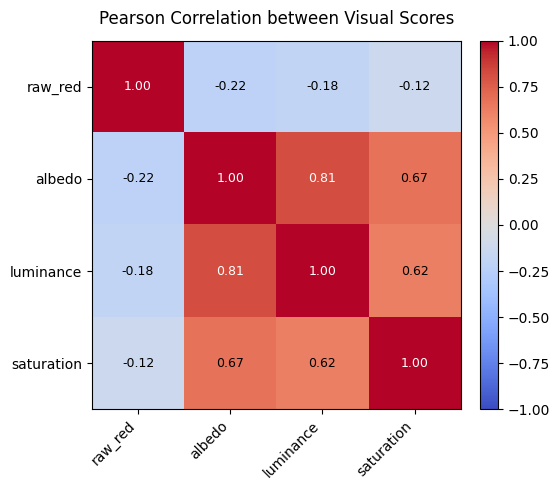

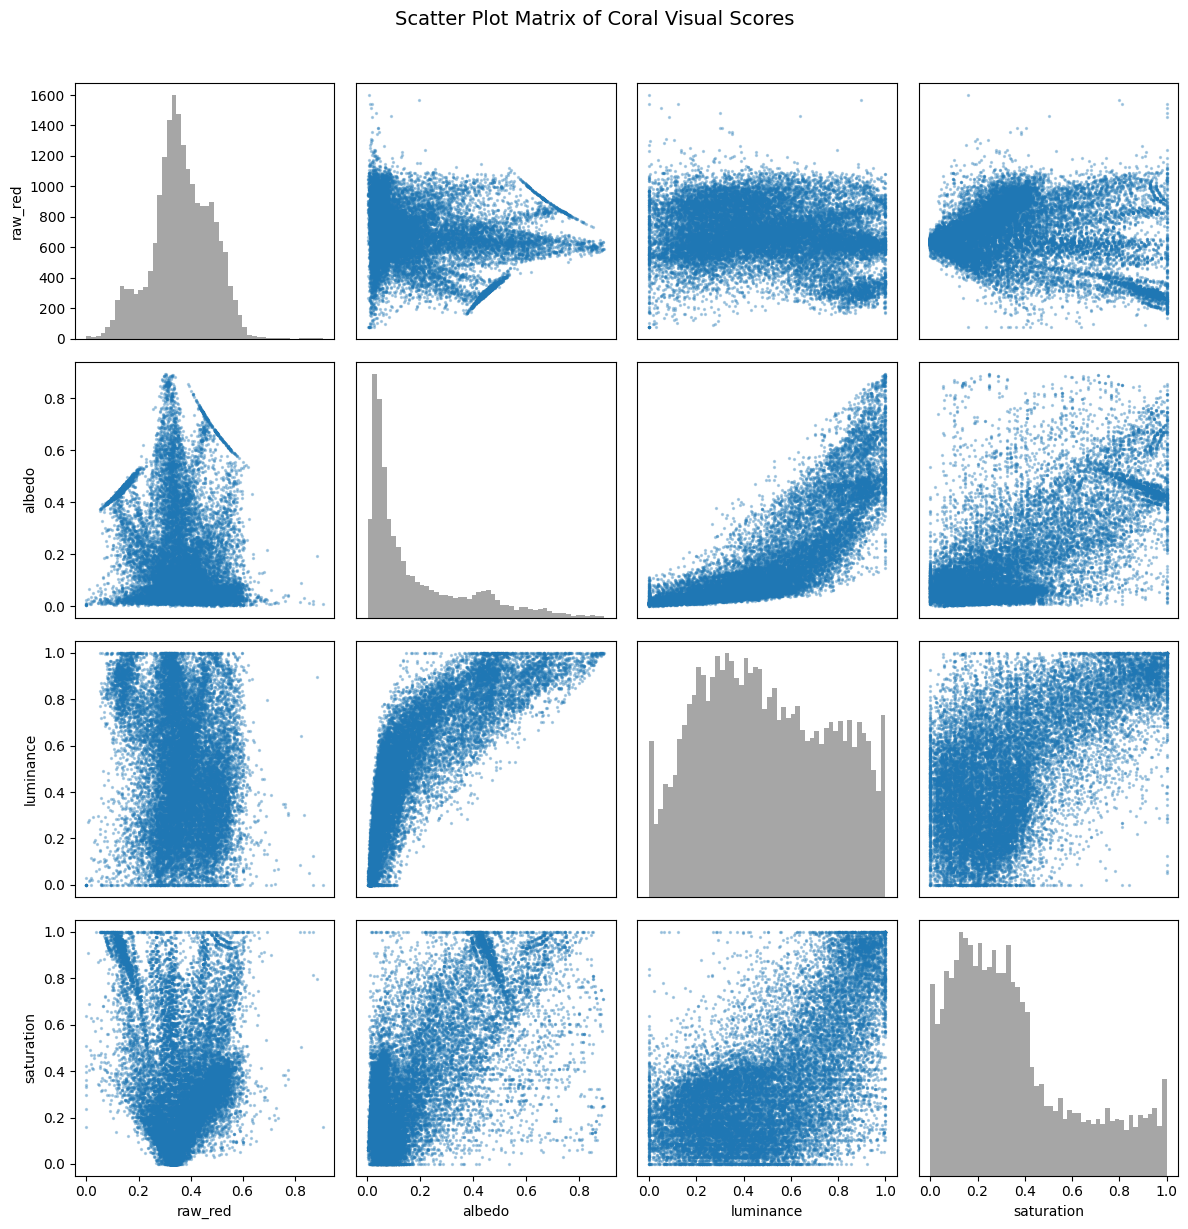

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ==========================================================
# === COMPUTE CORRELATIONS ACROSS DATASET ==================
# ==========================================================
def compute_score_correlations(path_triples, sample_per_image=50_000, max_points_total=2_000_000, random_state=42):
    import cv2
    rng = np.random.default_rng(random_state)

    acc = {k: [] for k in ["raw_red", "albedo", "luminance", "saturation"]}
    total_points = 0
    hard_cap = max_points_total if max_points_total is not None else np.inf

    def _sample_indices(n, k):
        if k is None or k >= n:
            return np.arange(n)
        return rng.choice(n, size=k, replace=False)

    for img_path, mb_path, mn_path in path_triples:
        img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if img_bgr is None:
            continue
        H, W = img_bgr.shape[:2]

        mask_b = load_mask(mb_path, (H, W))
        mask_n = load_mask(mn_path, (H, W))
        if mask_b is None and mask_n is None:
            continue
        coral_mask = (mask_b if mask_b is not None else np.zeros((H, W), bool)) | \
                     (mask_n if mask_n is not None else np.zeros((H, W), bool))
        if not coral_mask.any():
            continue

        _, _, raw_red, albedo, luminance, saturation = create_all_scores(img_bgr, coral_mask)
        rr, al, lu, sa = (raw_red[coral_mask], albedo[coral_mask], luminance[coral_mask], saturation[coral_mask])
        valid = np.isfinite(rr) & np.isfinite(al) & np.isfinite(lu) & np.isfinite(sa)
        if not valid.any():
            continue
        rr, al, lu, sa = rr[valid], al[valid], lu[valid], sa[valid]

        idx = _sample_indices(len(rr), sample_per_image)
        rr, al, lu, sa = rr[idx], al[idx], lu[idx], sa[idx]

        remaining = int(hard_cap - total_points)
        if remaining <= 0:
            break
        if len(rr) > remaining:
            rr, al, lu, sa = rr[:remaining], al[:remaining], lu[:remaining], sa[:remaining]

        acc["raw_red"].append(rr)
        acc["albedo"].append(al)
        acc["luminance"].append(lu)
        acc["saturation"].append(sa)
        total_points += len(rr)

    if total_points == 0:
        raise ValueError("No valid coral pixels found.")

    df = pd.DataFrame({
        "raw_red": np.concatenate(acc["raw_red"]),
        "albedo": np.concatenate(acc["albedo"]),
        "luminance": np.concatenate(acc["luminance"]),
        "saturation": np.concatenate(acc["saturation"]),
    })

    corr_pearson = df.corr(method="pearson")
    corr_spearman = df.corr(method="spearman")
    return df, corr_pearson, corr_spearman


# ==========================================================
# === VISUALIZATION HELPERS ================================
# ==========================================================
def plot_correlation_heatmap(corr_df, title="Correlation Heatmap"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(corr_df, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(np.arange(len(corr_df.columns)))
    ax.set_yticks(np.arange(len(corr_df.index)))
    ax.set_xticklabels(corr_df.columns, rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(corr_df.index, fontsize=10)
    for i in range(len(corr_df)):
        for j in range(len(corr_df.columns)):
            val = corr_df.iloc[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                    color="white" if abs(val) > 0.7 else "black", fontsize=9)
    ax.set_title(title, fontsize=12, pad=12)
    plt.tight_layout()
    plt.show()


def plot_scatter_matrix(df, sample=20000):
    if len(df) > sample:
        df = df.sample(sample, random_state=42)
    cols = df.columns
    n = len(cols)
    fig, axes = plt.subplots(n, n, figsize=(3*n, 3*n))
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            if i == j:
                ax.hist(df[cols[i]], bins=50, color="gray", alpha=0.7)
            else:
                ax.scatter(df[cols[j]], df[cols[i]], s=2, alpha=0.3)
            if i == n-1:
                ax.set_xlabel(cols[j], fontsize=10)
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(cols[i], fontsize=10)
            else:
                ax.set_yticks([])
    plt.suptitle("Scatter Plot Matrix of Coral Visual Scores", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


# ==========================================================
# === MAIN EXECUTION =======================================
# ==========================================================
df, corr_pearson, corr_spearman = compute_score_correlations(test_set)

print("✅ Pearson correlation matrix:\n", corr_pearson.round(3))
print("\n✅ Spearman correlation matrix:\n", corr_spearman.round(3))

plot_correlation_heatmap(corr_pearson, "Pearson Correlation between Visual Scores")
plot_scatter_matrix(df)


Exact Pearson computed over ~1,991,056,507 coral pixels.

Pearson correlation:
             raw_red  albedo  luminance  saturation
raw_red       1.000  -0.193     -0.084       0.013
albedo       -0.193   1.000      0.798       0.521
luminance    -0.084   0.798      1.000       0.451
saturation    0.013   0.521      0.451       1.000

Spearman (on reservoir sample):
             raw_red  albedo  luminance  saturation
raw_red       1.000  -0.155     -0.080       0.172
albedo       -0.155   1.000      0.883       0.346
luminance    -0.080   0.883      1.000       0.374
saturation    0.172   0.346      0.374       1.000


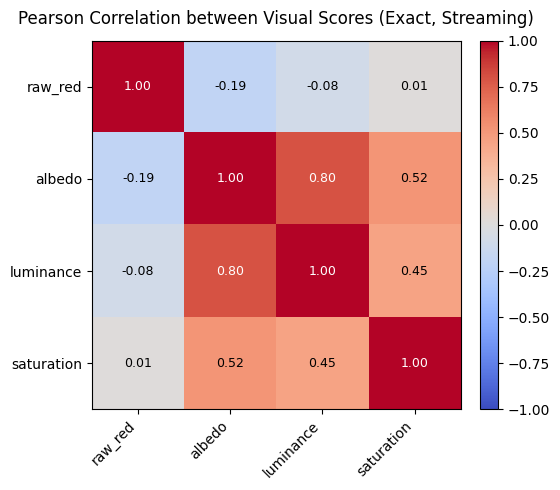

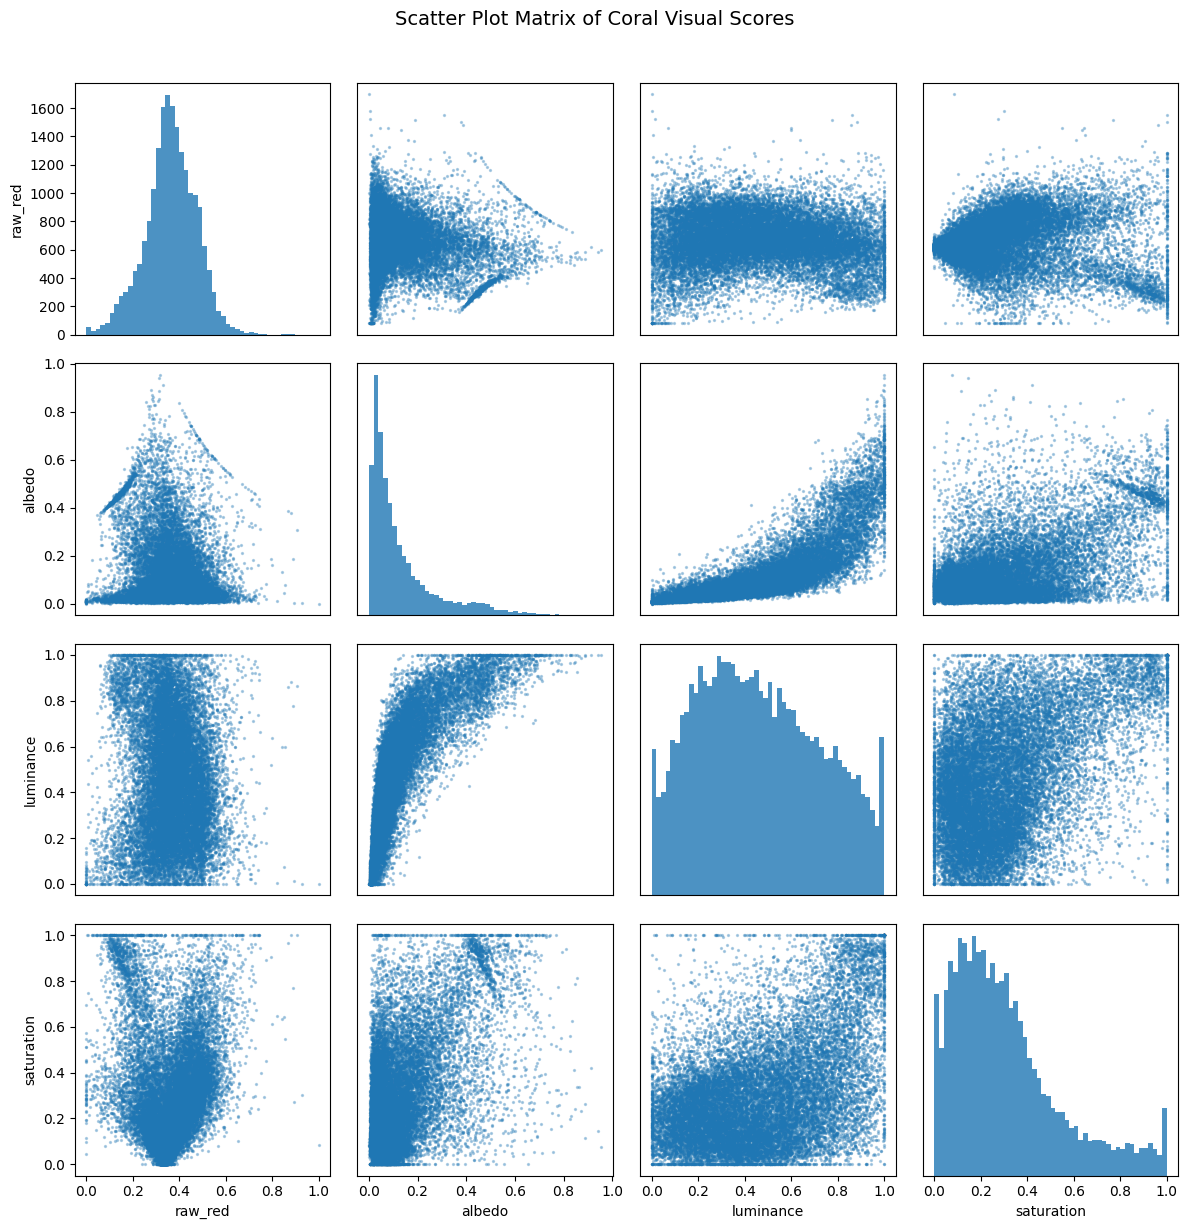

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ===============================
# Streaming Pearson + Reservoir
# ===============================

def stream_pearson_and_reservoir(
    path_triples,
    reservoir_cap=150_000,         # how many points to keep for scatter plots
    random_state=42,
    spearman_on_reservoir=True     # optional sampled Spearman on the reservoir
):
    """
    One-pass exact Pearson correlation over all valid coral pixels (no sampling),
    plus a uniform reservoir for visualization.

    Returns:
        pearson_df: 4x4 DataFrame of exact Pearson correlations
        sample_df:  DataFrame of reservoir sample (for scatter matrix)
        spearman_df: Spearman on the reservoir (or None)
        n_total: total number of coral pixels used
    """
    rng = np.random.default_rng(random_state)

    # We’ll track sums for mean and covariance:
    # For 4 variables (RR, AL, LU, SA), we need sum(x), sum(x^2), and sum(xy) for each pair.
    names = ["raw_red", "albedo", "luminance", "saturation"]
    k = len(names)

    n_total = 0
    sum_x  = np.zeros(k, dtype=np.float64)
    sum_x2 = np.zeros(k, dtype=np.float64)
    sum_xy = np.zeros((k, k), dtype=np.float64)

    # Reservoir buffers for plotting
    res = {name: [] for name in names}
    res_count = 0  # total items seen for reservoir replacement

    def add_to_stream(rr, al, lu, sa):
        nonlocal n_total, sum_x, sum_x2, sum_xy, res_count

        X = np.stack([rr, al, lu, sa], axis=1).astype(np.float64, copy=False)
        # Remove any leftover non-finite (should be rare)
        ok = np.isfinite(X).all(axis=1)
        if not ok.any():
            return
        X = X[ok]
        m = X.shape[0]
        if m == 0:
            return

        # Update totals
        n_total += m
        sum_x  += X.sum(axis=0)
        sum_x2 += (X * X).sum(axis=0)
        sum_xy += X.T @ X

        # Reservoir sampling (Vitter’s algorithm R)
        for row in X:
            res_count += 1
            if len(res[names[0]]) < reservoir_cap:
                for i, name in enumerate(names):
                    res[name].append(row[i])
            else:
                j = rng.integers(0, res_count)
                if j < reservoir_cap:
                    for i, name in enumerate(names):
                        res[name][j] = row[i]

    # ==== Stream over dataset ====
    for img_path, mb_path, mn_path in path_triples:
        img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if img_bgr is None:
            continue
        H, W = img_bgr.shape[:2]

        mask_b = load_mask(mb_path, (H, W))
        mask_n = load_mask(mn_path, (H, W))
        if mask_b is None and mask_n is None:
            continue
        coral_mask = (mask_b if mask_b is not None else np.zeros((H, W), bool)) | \
                     (mask_n if mask_n is not None else np.zeros((H, W), bool))
        if not coral_mask.any():
            continue

        _, _, raw_red, albedo, luminance, saturation = create_all_scores(img_bgr, coral_mask)

        rr = raw_red[coral_mask]
        al = albedo[coral_mask]
        lu = luminance[coral_mask]
        sa = saturation[coral_mask]

        # filter invalids per-variable
        valid = np.isfinite(rr) & np.isfinite(al) & np.isfinite(lu) & np.isfinite(sa)
        if not valid.any():
            continue

        add_to_stream(rr[valid], al[valid], lu[valid], sa[valid])

    if n_total == 0:
        raise ValueError("No valid coral pixels found across the dataset.")

    # ==== Exact Pearson from streaming stats ====
    mean = sum_x / n_total
    # Var = E[X^2] - (E[X])^2
    ex2 = sum_x2 / n_total
    var = ex2 - mean * mean
    std = np.sqrt(np.maximum(var, 0.0))
    # Cov = E[XY] - E[X]E[Y]
    exy = sum_xy / n_total
    cov = exy - np.outer(mean, mean)
    denom = np.outer(std, std)
    with np.errstate(invalid="ignore", divide="ignore"):
        pearson = cov / denom
    # Clean up any 0-variance issues (NaNs)
    pearson = np.where(np.isfinite(pearson), pearson, 0.0)
    pearson_df = pd.DataFrame(pearson, index=names, columns=names)

    # Reservoir sample DataFrame
    sample_df = pd.DataFrame({name: np.array(vals, dtype=np.float32) for name, vals in res.items()})

    # Optional Spearman on the reservoir
    if spearman_on_reservoir and len(sample_df) > 1:
        spearman_df = sample_df.corr(method="spearman")
    else:
        spearman_df = None

    return pearson_df, sample_df, spearman_df, n_total


# ===============================
# Plotting helpers
# ===============================

def plot_correlation_heatmap(corr_df, title="Correlation Heatmap"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(corr_df, vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(np.arange(len(corr_df.columns)))
    ax.set_yticks(np.arange(len(corr_df.index)))
    ax.set_xticklabels(corr_df.columns, rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(corr_df.index, fontsize=10)
    for i in range(len(corr_df)):
        for j in range(len(corr_df.columns)):
            v = corr_df.iloc[i, j]
            ax.text(j, i, f"{v:.2f}", ha="center", va="center",
                    color="white" if abs(v) > 0.7 else "black", fontsize=9)
    ax.set_title(title, fontsize=12, pad=12)
    plt.tight_layout()
    plt.show()


def plot_scatter_matrix(df, sample=20000):
    # For plotting speed, downsample the reservoir if it’s huge
    if len(df) > sample:
        df = df.sample(sample, random_state=42)
    cols = df.columns
    n = len(cols)
    fig, axes = plt.subplots(n, n, figsize=(3*n, 3*n))
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            if i == j:
                ax.hist(df[cols[i]], bins=50, alpha=0.8)
            else:
                ax.scatter(df[cols[j]], df[cols[i]], s=2, alpha=0.3)
            if i == n - 1:
                ax.set_xlabel(cols[j], fontsize=10)
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(cols[i], fontsize=10)
            else:
                ax.set_yticks([])
    plt.suptitle("Scatter Plot Matrix of Coral Visual Scores", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


# ===============================
# Run it
# ===============================
pearson_df, sample_df, spearman_df, n_used = stream_pearson_and_reservoir(
    test_set,
    reservoir_cap=150_000,        # tweak as you like for smoother plots
    random_state=42,
    spearman_on_reservoir=True
)

print(f"Exact Pearson computed over ~{n_used:,} coral pixels.")
print("\nPearson correlation:\n", pearson_df.round(3))
if spearman_df is not None:
    print("\nSpearman (on reservoir sample):\n", spearman_df.round(3))

plot_correlation_heatmap(pearson_df, "Pearson Correlation between Visual Scores (Exact, Streaming)")
plot_scatter_matrix(sample_df)
